In [51]:
import pickle
from functools import partial
from os import listdir
from os.path import isfile, join

import numpy as np
import pandas as pd
import scipy
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit

from common import CityResult
from file_name_generator import generate_new_name


Загрузка данных

In [52]:
mypath = '../clusters_results/2024_06_11'

In [53]:
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

r : dict[str:CityResult]= {}
for name in onlyfiles:
    with open(join(mypath, name), 'rb') as f:
        r[name] = pickle.load(f)
        f.close()

Обработка данных

In [54]:
def func(x,a,b):
    return b*(x**a)

In [55]:
q = list(r.items())
q.sort(key = lambda x: x[1].density)
r = dict(q)

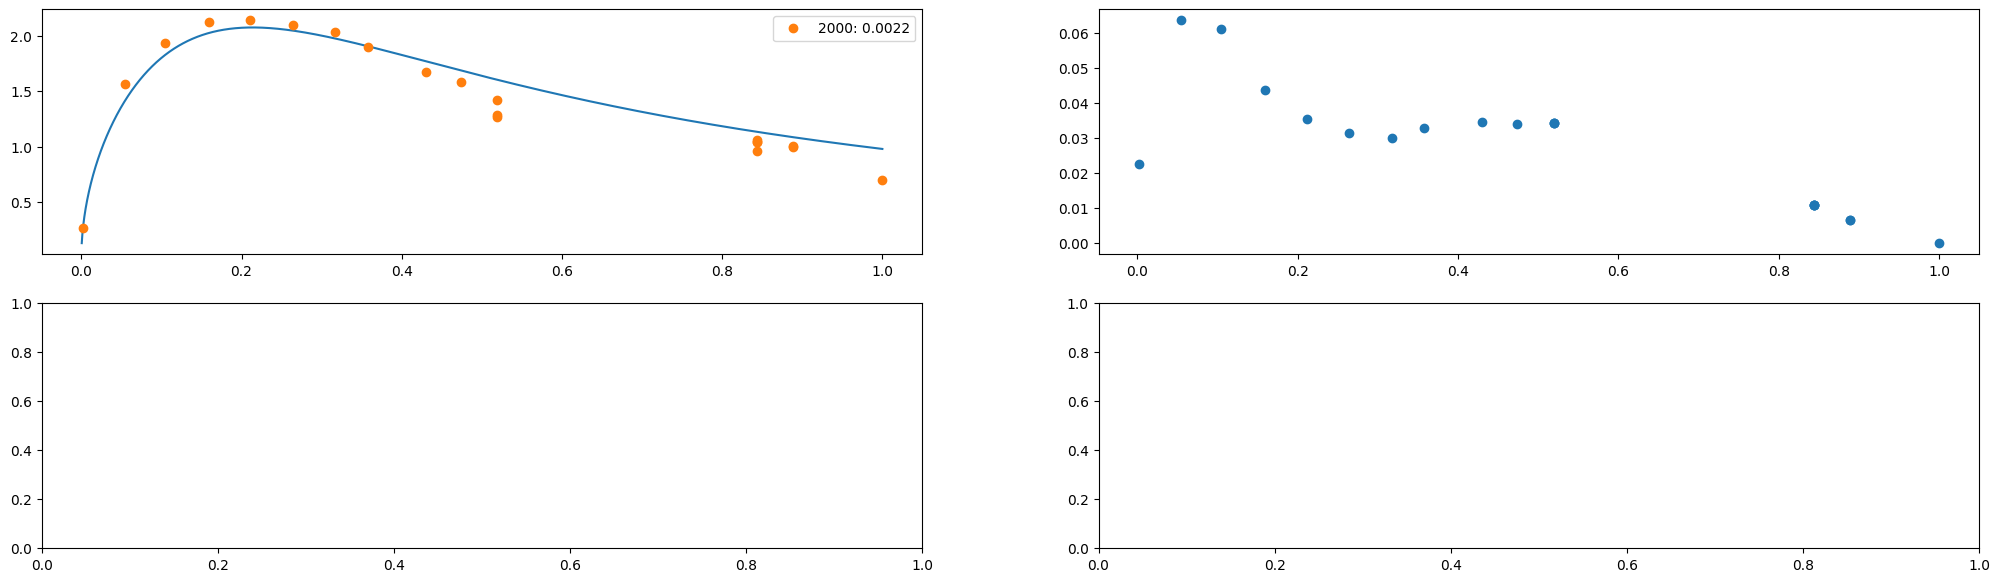

In [56]:
from common import CentroidResult
fig, axss = plt.subplots(1* len(r) + 1,2)
fig.set_figwidth(25)
fig.set_figheight(7 * len(r))
i = 0
for name in r:
    res: CityResult = r[name]
    X = [p.alpha for p in res.points_results]
    E = [np.mean(p.errors) for p in res.points_results]
    S = [np.mean(p.speed_up) for p in res.points_results]
    # print(np.mean([p.centroid_edges/p.centroid_nodes for p in res.points_results]),np.std([p.centroid_edges/p.centroid_nodes for p in res.points_results]) )
    N = res.nodes
    # print(res.density)
    def ax(x, c1=1,c2=2):    
        b1 = np.mean([p.centroid_edges/p.centroid_nodes for p in res.points_results])
        b0 = res.edges/res.nodes
        k = c1/np.sqrt(x*N)*(1-np.log(x)/np.log(N)) + x*b1/b0*(1+np.log(x)/np.log(N)) + c2*(1 + b0)/(np.sqrt(x*N)*b0*np.log(N))
        return 1/k

    axs = axss[i,:]
    
    popt = curve_fit(ax, X,S, p0 = [1,1], bounds=(1,40))
    
    x = np.linspace(1/N,1,5000)
    # q = popt[1]
    # q = [5]
    # print(*popt[0])
    y = ax(x, *popt[0])
    # print(res.nodes,x[np.argmax(y)], X[np.argmax(A)])
    axs[0].errorbar(x, y)
    
    axs[0].errorbar(X, S, fmt='o', label = "{}: {:.4f}".format(r[name].nodes, res.density))
    # axs[0].set(xlabel='resolution', ylabel='alpha')
    axs[1].errorbar(X, E, fmt='o', label = "{}: {}".format(name, r[name].nodes))
    axs[0].legend()
    i+=1
    # axs[1].set(xlabel='resolution', ylabel='alpha')
    # print(X)
fig.patch.set_alpha(1)

Графики:

Построим график ускорения от плотности

Уберем последние 4 точки